# Librerías

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import time
import platform
import random
from gcn_model import GCN
from torch_geometric.loader import DataLoader
from dataset_utils import generate_edge_index, build_graph_list, build_graph_from_sample
from train_eval import train, evaluate

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# Propiedades del sistema
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda
    print("system_specs", system_specs)


system_specs {'os': 'Windows', 'os_version': '10.0.22000', 'machine': 'AMD64', 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel', 'python_version': '3.12.9', 'device': 'cuda', 'gpu_name': 'NVIDIA GeForce RTX 2060', 'gpu_memory_total_GB': 6.0, 'cuda_version': '12.1'}


In [4]:
dir_path = os.getcwd()
print(dir_path)

c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\ia_thermal\ernestoemedina\GCN_MK1


In [5]:
# Ruta del dataset completo
dataset_path = os.path.join(dir_path, "Datasets", "PCB_dataset.pth")
norm_dataset_path = os.path.join(dir_path, "Datasets", "PCB_Dataset_Norm.pth")

# Cargar dataset
dataset = torch.load(dataset_path)
norm_dataset = torch.load(norm_dataset_path)

C:\Users\ramse\AppData\Local\Temp\ipykernel_9308\3411024544.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
C:\Users\ramse\AppData\Loc

## Para desnormalizar

In [6]:
# Cargar la info de normalización
info_path = os.path.join(os.getcwd(), "Datasets", "normalization_info.pth")
norm_info = torch.load(info_path)

max_T_interfaces = norm_info["max_T_interfaces"]
max_Q_heaters = norm_info["max_Q_heaters"]
max_T_env = norm_info["max_T_env"]

## En ppio no debería ser necesario, ya que hemos cargado el dataset sin normalizar

def desnormalize_inputs(dataset_norm, idx):
    T_interfaces_norm = dataset_norm.T_interfaces[idx]
    Q_heaters_norm = dataset_norm.Q_heaters[idx]
    T_env_norm = dataset_norm.T_env[idx]
    
    T_interfaces_real = T_interfaces_norm * max_T_interfaces
    Q_heaters_real = Q_heaters_norm * max_Q_heaters
    T_env_real = T_env_norm * max_T_env
    
    return T_interfaces_real, Q_heaters_real, T_env_real

C:\Users\ramse\AppData\Local\Temp\ipykernel_9308\1878969574.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_info = torch.load(info_path)


In [7]:
idx = 1
T_interfaces_real, Q_heaters_real, T_env_real = desnormalize_inputs(norm_dataset, idx)

# Por ejemplo:
print(torch.max(T_interfaces_real), "K")
print(torch.max(Q_heaters_real), "W")
print(torch.max(T_env_real), "K")


tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [8]:
# Seleccionar un índice para graficar
idx = 1  # Puedes cambiar este valor

# Obtener los valores reales de las CC en T, Q y T_env
T_interfaces_real = dataset.denormalize_T_interfaces(dataset.T_interfaces)
Q_heaters_real = dataset.denormalize_Q_heaters(dataset.Q_heaters)
T_env_real = dataset.denormalize_T_env(dataset.T_env)

print(T_interfaces_real.shape)
print(torch.max(T_interfaces_real[idx]), "K")
print(torch.max(Q_heaters_real[idx]), "W")
print(torch.max(T_env_real[idx]), "K")


torch.Size([10000, 13, 13])
tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [9]:
idx = 10
T_interfaces_norm = norm_dataset.T_interfaces[idx]
Q_heaters_norm = norm_dataset.Q_heaters[idx]
T_env_norm = norm_dataset.T_env[idx]

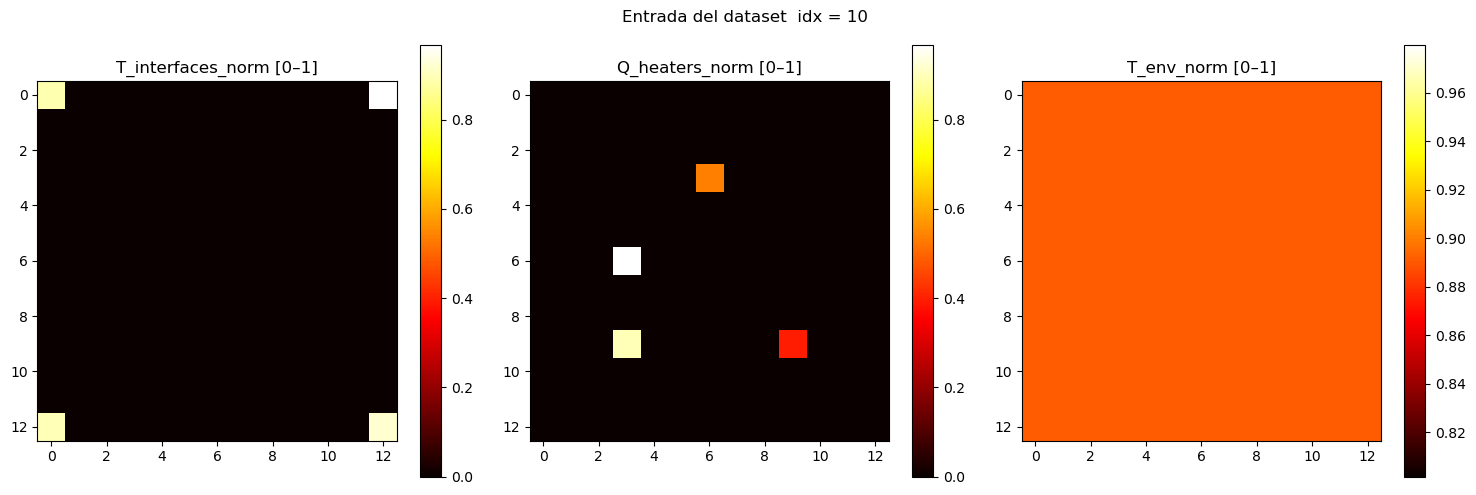

In [10]:
# Crear figura para mostrar las 3 variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = axs[0].imshow(T_interfaces_norm.numpy(), cmap='hot')
axs[0].set_title("T_interfaces_norm [0–1]")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(Q_heaters_norm.numpy(), cmap='hot')
axs[1].set_title("Q_heaters_norm [0–1]")
plt.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(T_env_norm.numpy(), cmap='hot')
axs[2].set_title("T_env_norm [0–1]")
plt.colorbar(im3, ax=axs[2])

plt.suptitle(f"Entrada del dataset  idx = {idx}")
plt.tight_layout()
plt.show()

## GCN

### Configuración de la red

In [11]:
# Configuración del modelo
config = {
    "input_dim": 3,           # 3 canales: T_interfaces, Q_heaters, T_env
    "hidden_dim": 64,
    "output_dim": 1,
    "num_layers": 3,
    "use_dropout": True,
    "dropout_rate": 0.3,
    "use_batchnorm": True,
    "use_residual": False,
    "batch_size": 32,
    "lr": 0.001,
    "epochs": 20,
    "error_threshold_K": 5.0,
    "use_percentage_threshold": False,
    "percentage_threshold": 10.0,  # solo si se activa la opción
    "save_model": True
}

In [12]:
grid_size = norm_dataset.inputs.shape[-1]
print("PCB cuadrada de", grid_size, "nodos por lado")
edge_index = generate_edge_index(grid_size=grid_size) # Matriz de adyacencia bidireccional
graphs = build_graph_list(norm_dataset, edge_index)

PCB cuadrada de 13 nodos por lado


In [13]:
# Por si en algún momento el Dataset tuviera un patrón al ser generado
random.seed(42)
random.shuffle(graphs)

In [14]:

# Ruta al dataset normalizado

# Extraer un tensor de salida
sample_output = norm_dataset.outputs[0]

# Imprimir estadísticas globales de outputs
all_outputs = norm_dataset.outputs.view(-1)
print(f"Mean of outputs: {all_outputs.mean().item():.4f}")
print(f"Std of outputs:  {all_outputs.std().item():.4f}")

# También desde los atributos si están disponibles
if hasattr(norm_dataset, "T_outputs_mean"):
    print(f"\nAtributo .T_outputs_mean: {norm_dataset.T_outputs_mean.item():.4f}")
    print(f"Atributo .T_outputs_std:  {norm_dataset.T_outputs_std.item():.4f}")


Mean of outputs: 0.8303
Std of outputs:  0.0338

Atributo .T_outputs_mean: 0.0000
Atributo .T_outputs_std:  1.0000


### División Dataset

In [15]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

In [17]:
print("Forma de entrada:", norm_dataset.inputs[0].shape)
print("Forma de salida:", norm_dataset.outputs[0].shape)


Forma de entrada: torch.Size([3, 13, 13])
Forma de salida: torch.Size([13, 13])


### Entrenamiento

In [18]:
# Entrenamiento

print("Iniciando entrenamiento...")
for epoch in range(config["epochs"]):
    train_loss = train(model, train_loader, optimizer, device)

    val_mse, val_mae, val_r2, val_accuracy = evaluate(
        model, val_loader, device,
        error_threshold=config["error_threshold_K"],
        percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
        plot_results=False
    )

    print(f"Epoch {epoch+1}/{config['epochs']} - "
          f"Loss: {train_loss:.6f} | "
          f"Val MSE: {val_mse:.6f} | "
          f"Val MAE: {val_mae:.6f} | "
          f"Val R²: {val_r2:.4f} | "
          f"Val Accuracy: {val_accuracy:.2f}%")

Iniciando entrenamiento...


c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\ia_thermal\ernestoemedina\GCN_MK1\train_eval.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_info = to

Epoch 1/20 - Loss: 0.084446 | Val MSE: 0.009170 | Val MAE: 0.077715 | Val R²: -7.3729 | Val Accuracy: 11.06%
Epoch 2/20 - Loss: 0.021562 | Val MSE: 0.004162 | Val MAE: 0.051253 | Val R²: -2.7927 | Val Accuracy: 17.15%
Epoch 3/20 - Loss: 0.010694 | Val MSE: 0.002417 | Val MAE: 0.037471 | Val R²: -1.2095 | Val Accuracy: 26.61%
Epoch 4/20 - Loss: 0.006539 | Val MSE: 0.001987 | Val MAE: 0.034559 | Val R²: -0.8121 | Val Accuracy: 26.00%
Epoch 5/20 - Loss: 0.004474 | Val MSE: 0.001539 | Val MAE: 0.030380 | Val R²: -0.4034 | Val Accuracy: 31.35%
Epoch 6/20 - Loss: 0.003325 | Val MSE: 0.001613 | Val MAE: 0.030863 | Val R²: -0.4710 | Val Accuracy: 30.51%
Epoch 7/20 - Loss: 0.002596 | Val MSE: 0.001340 | Val MAE: 0.027941 | Val R²: -0.2228 | Val Accuracy: 34.38%
Epoch 8/20 - Loss: 0.002061 | Val MSE: 0.001128 | Val MAE: 0.025879 | Val R²: -0.0284 | Val Accuracy: 35.66%
Epoch 9/20 - Loss: 0.001668 | Val MSE: 0.001026 | Val MAE: 0.024830 | Val R²: 0.0646 | Val Accuracy: 36.48%
Epoch 10/20 - Loss: 

### Evaluación

Evaluando en test set con visualización de un ejemplo:


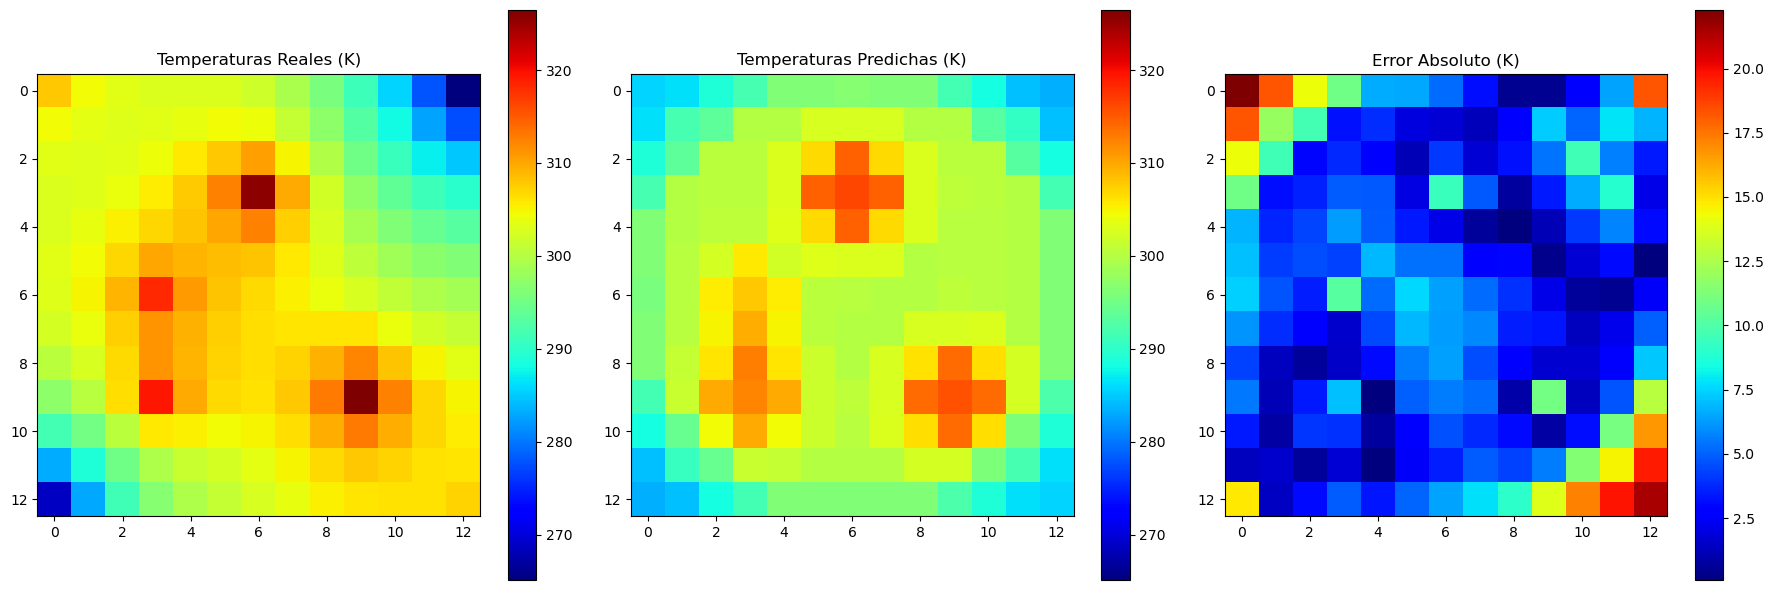

Resultados del test:
MSE       : 0.000345
MAE       : 0.014578
R²        : 0.6721
Accuracy  : 55.79%


In [21]:
# Evaluar en test y graficar un ejemplo
print("Evaluando en test set con visualización de un ejemplo:")
val_mse, val_mae, val_r2, val_accuracy = evaluate(
    model, test_loader, device,
    error_threshold=config["error_threshold_K"],
    percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
    plot_results=True
)

print("Resultados del test:")
print(f"MSE       : {val_mse:.6f}")
print(f"MAE       : {val_mae:.6f}")
print(f"R²        : {val_r2:.4f}")
print(f"Accuracy  : {val_accuracy:.2f}%")

### Guardado del modelo ya entrenado

In [22]:
# Crear nombre de archivo con los hiperparámetros clave
model_name = (
    f"GCN_Layers_{config['num_layers']}_"
    f"HDim_{config['hidden_dim']}_"
    f"Epochs_{config['epochs']}_"
    f"Lr_{config['lr']}_"
    f"Batch_{config['batch_size']}.pth"
)

# Crear carpeta si no existe
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Guardar el modelo
model_path = os.path.join(save_dir, model_name)
if config["save_model"]:
    # Guardar el modelo entrenado
    torch.save(model.state_dict(), model_path)

    print(f" Modelo guardado en: {model_path}")

 Modelo guardado en: saved_models\GCN_Layers_3_HDim_64_Epochs_20_Lr_0.001_Batch_32.pth


### Predicción

In [ ]:

fr train_eval import predict
from dataset_utils import load_latest_model
# Cargar el modelo más reciente
model = GCN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
)

model = load_latest_model(model)

# Predecir sobre test
predicciones = predict(model, test_loader)

print("Predicciones shape:", predicciones.shape)